In [1]:
seed_value = 42

import random
# set python seed
random.seed(seed_value)
from math import log, exp, sqrt, sin, cos, pi
import numpy
# set numpy seed
numpy.random.seed(seed_value)
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow
# set tf seed
tensorflow.random.set_seed(seed_value)
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout

import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

# Load the TensorBoard notebook extension
#%load_ext tensorboard
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
print(tensorflow.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [2]:
#%reload_ext tensorboard

In [3]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good

def mean_arctangent_absolute_percentage_error(actual, predicted):

    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [4]:
# train the model
def build_model(train, n_input, n_output, stride, units=64, epochs=50, batch_size=0):
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_output, stride)
    # Model variables
    verbose = 1 #batch_size 1 IS SGD, 1<BATCH_SIZE<SIZE IS MINIBATCH GD AND BATCH_SIZE=SIZE IS BATCH GD
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    
    # final data preparation for the model
    # reshape train_output into [samples, timesteps, features] for the LSTMs
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    
    # define model
    model = Sequential()
    
    # BIDIRECTIONAL
    """
    model.add(Bidirectional(LSTM(256, activation='tanh', input_shape=(n_timesteps, n_features))))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(n_output))
    """

    # DEEPER LSTM
    """
    model.add(LSTM(100, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(75, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_output))
    """
    
    # TIMEDISTRIBUTED LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    """
    # VANILLA LSTM
    
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add((Dense(n_output)))
    
    
    # SEQ2SEQ LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(units, activation='tanh', return_sequences=True))   # Reminder: Other activation fuctions?
    model.add(TimeDistributed(Dense(1)))
    """
    # STATEFUL LSTM
    """
    model.add(LSTM(n_output, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True))
    #model.add(Dense(n_output))
    model.compile(loss="mse", optimizer='adam')  # can be "mse" and the functions on top
    for i in range(epochs):
        model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False)
        model.reset_states()
    """
    model.compile(loss="mse", optimizer='adam', metrics=["mae"])  #Reminder: LOSS function is MSE but others can be used!
    
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  
    #tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=10)

    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early]) #tensorboard_callback,
    print(model.summary())
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model

In [5]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False) 

    # Perform the augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
# load the csv file
# ../old_data//30min/30minstore290.csv
# ../old_data/30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../old_data/30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../old_data/30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../old_data/30min/predict_covid_30minstore274


# NEW STORES
# ../Treatment/imputed_stores/linear_interp_store0057.csv
# ../Treatment/new_stores/store_0057.csv

# ../Treatment/imputed_stores/linear_interp_store4969.csv
# ../Treatment/new_stores/store_4969.csv




# IMPUTED DATASET
dataset = pd.read_csv('../Treatment/imputed_stores/linear_interp_store0057.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
# NORMAL DATASET
#dataset = pd.read_csv('../Treatment/new_stores/store_0057.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
print(dataset)

                     sales  n_clients imputed
ds                                           
2015-01-02 09:00:00  49.12       24.0     yes
2015-01-02 09:30:00  49.12       24.0     yes
2015-01-02 10:00:00  49.12       24.0      no
2015-01-02 10:30:00  42.00       22.0      no
2015-01-02 11:00:00  88.10       35.0      no
...                    ...        ...     ...
2019-07-23 19:00:00  63.23       21.0      no
2019-07-23 19:30:00  41.00       18.0      no
2019-07-23 20:00:00  39.00       22.0      no
2019-07-23 20:30:00  70.00       25.0      no
2019-07-23 21:00:00  59.00       28.0      no

[41225 rows x 3 columns]


In [7]:
# PARAMETERS
dataset_day = 25
n_input = dataset_day*3 # steps used to predict (autoregressive order) p
n_output = dataset_day*30              # steps to predict (forecast horizon) H
data_split = n_output        # to split the data in windows
stride = 1                   # stride value for the sliding window method (overlapped vs non-overlapped)
test_set = n_output*3          # last observations for the test_set
init_train_set = 725           # refers to when the train_set starts, this is useful for the sliding window method
walkforward = True           # walkforward validation 
encode_weekday = False       # If the string weekday is included in the dataset
imputed = True                # To remove idxs in evaluation from a supposed imputed model
compare_imputed = False        # If the results are to be compared to an imputed version, False if we're not trying to compare

# Remove seasonality (and trend) if necessary
remove_components = False


# IMPORTANT WARNING! 
# If n_output is too large and there's not enough train data to split, 
# consider having a one shot large prediction over the test_set (not future) without splitting
# This is used when the train/test ratio is 50(or less)/50 and walkforward is not required!
# This can be used with future_prediction and two predictions are calculated
single_prediction = False


# Add n_output (H) zeros to the dataset to get the real FUTURE predictions
future_prediction = False
    

# the changes if a large single prediction is conducted
if single_prediction:
    walkforward = False
    test_set = n_output
    data_split = 1
    
    
print("Train beginning:\n")
print(dataset.iloc[init_train_set])
dataset = dataset.iloc[init_train_set:]
print("\nTrain end:\n")
print(dataset.iloc[-test_set-1])
print("\nTest beggining:\n")
print(dataset.iloc[-test_set])
print("\nTest end:\n")
print(dataset.iloc[-1])

print("\nParameters:    n_input / n_output / stride")
print(n_input, n_output, stride)


if imputed:
    # if imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    imputed_idx = numpy.where(dataset.imputed=="yes")[0].tolist()
    #imputed_idx = numpy.where(numpy.logical_or(dataset.imputed==1,dataset.imputed==0))[0].tolist()
elif compare_imputed:
    # if compare_imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    remove_idx = dataset.between_time('21:01', '08:59')
    remove_idx = numpy.where(dataset.index.isin(remove_idx.index))[0].tolist()


# Univariate
dataset = dataset[['n_clients']]
dataset = dataset.astype('int64')
train_dataset = dataset.iloc[:-test_set]
n_features = len(dataset.columns)
print(dataset, n_features)

Train beginning:

sales        61
n_clients    10
imputed      no
Name: 2015-01-31 09:00:00, dtype: object

Train end:

sales        37
n_clients    11
imputed      no
Name: 2019-04-22 21:00:00, dtype: object

Test beggining:

sales        56
n_clients    24
imputed      no
Name: 2019-04-23 09:00:00, dtype: object

Test end:

sales        59
n_clients    28
imputed      no
Name: 2019-07-23 21:00:00, dtype: object

Parameters:    n_input / n_output / stride
75 750 1
                     n_clients
ds                            
2015-01-31 09:00:00         10
2015-01-31 09:30:00         17
2015-01-31 10:00:00         32
2015-01-31 10:30:00         33
2015-01-31 11:00:00         38
...                        ...
2019-07-23 19:00:00         21
2019-07-23 19:30:00         18
2019-07-23 20:00:00         22
2019-07-23 20:30:00         25
2019-07-23 21:00:00         28

[40500 rows x 1 columns] 1


19126 9131.310000000001 4.188884179816477


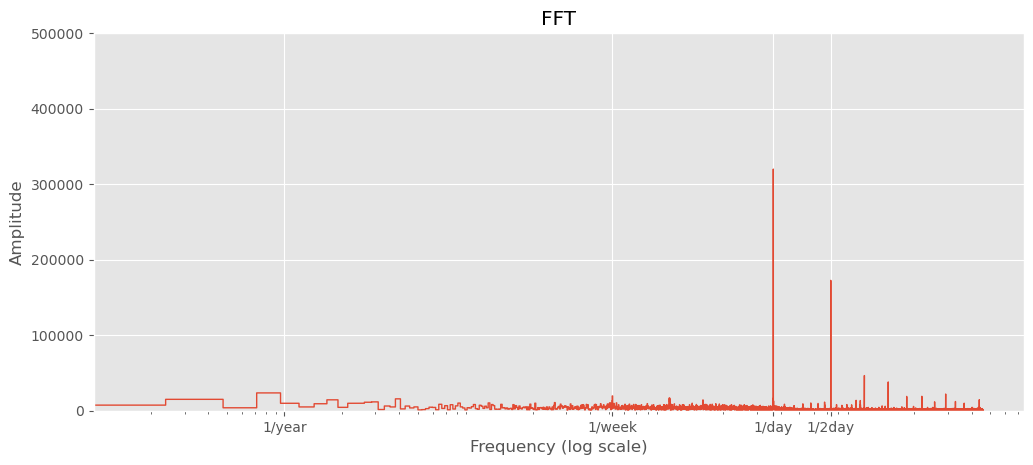

In [8]:
# FFT: Finding relevant seasonalities in high-frequency data
# Configurable: in the Chapter example, a day is 25 half hours

fft = tensorflow.signal.rfft(train_dataset['n_clients'])
f_per_dataset = arange(0, len(fft))

n_samples_h = len(train_dataset['n_clients'])
days_per_year = dataset_day*365.2524
years_per_dataset = n_samples_h/(days_per_year)

print(len(fft), days_per_year, years_per_dataset)

f_per_year = f_per_dataset/years_per_dataset
pyplot.step(f_per_year, numpy.abs(fft))
pyplot.title("FFT")
pyplot.xscale('log')
pyplot.ylim(0, 500000)
pyplot.xlim([0.1, max(pyplot.xlim())])
pyplot.xticks([1, 52.1428571429, 365.2524, 730.5048], labels=['1/year', '1/week', '1/day', '1/2day'])
_ = pyplot.xlabel('Frequency (log scale)')
pyplot.ylabel('Amplitude')
pyplot.show()

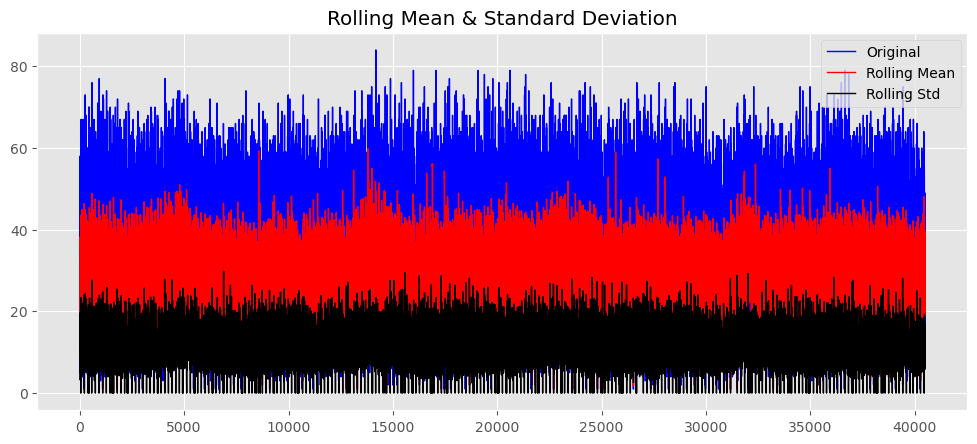

Results of Dickey-Fuller Test:
Test Statistic                   -23.927389
p-value                            0.000000
#Lags Used                        54.000000
Number of Observations Used    40445.000000
Critical Value (1%)               -3.430512
Critical Value (5%)               -2.861611
Critical Value (10%)              -2.566808
dtype: float64


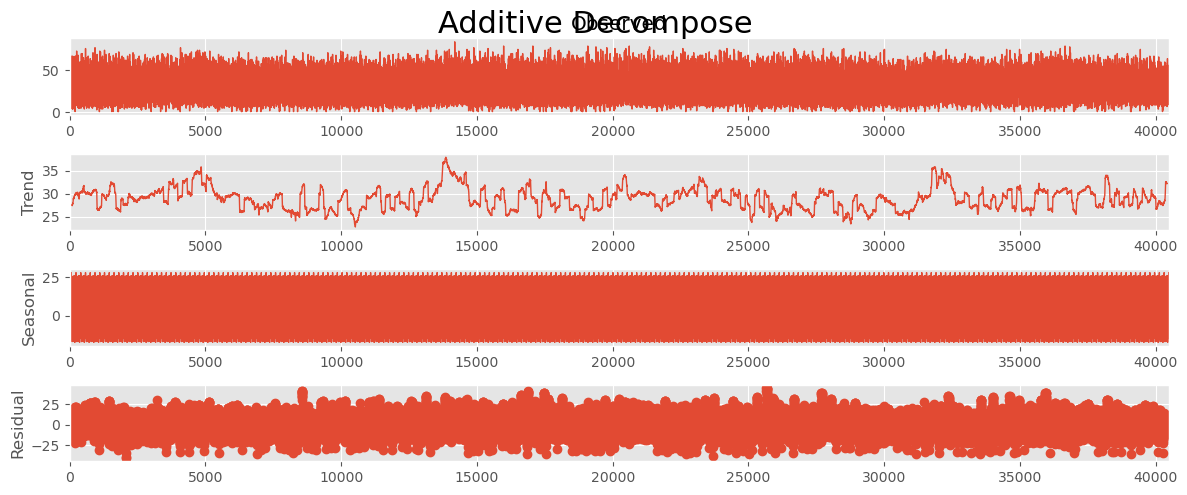

In [9]:
# Check components and stationarity of the forecast variable
forecast_variable = dataset['n_clients'].values

# Test stationarity
test_stationarity(forecast_variable)

# Additive Decomposition
result_add = seasonal_decompose(forecast_variable, model='additive', period=175)

# Plot components

result_add.plot().suptitle('Additive Decompose', fontsize=22)
pyplot.show()

In [10]:
#%matplotlib notebook
if remove_components:
    # Remove trend and seasonality, regression with fourier terms!
    forecast_variable = train_dataset.reset_index().drop(['ds'],axis=1)
    print(forecast_variable)

    # Time scale
    predic1 = range(len(train_dataset))
    model_day = True
    model_halfday = True
    model_week = False
    
    # K = 1
    if model_halfday:
        predic_halfday_cos = list(map(lambda x: cos(2*pi*x/(dataset_day/2.0)), predic1))
        predic_halfday_sin = list(map(lambda x: sin(2*pi*x/(dataset_day/2.0)), predic1))
    if model_day:
        #Applying the Fourier terms to the time scale
        predic_day_cos = list(map(lambda x: cos(2*pi*x/dataset_day), predic1))
        predic_day_sin = list(map(lambda x: sin(2*pi*x/dataset_day), predic1))
    if model_week:
        predic_week_cos = list(map(lambda x: cos(2*pi*x/(dataset_day*7)), predic1))
        predic_week_sin = list(map(lambda x: sin(2*pi*x/(dataset_day*7)), predic1))
    
    # Assembling the regressors
    if model_halfday and model_day and model_week: 
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_week_cos, predic_week_sin, predic_halfday_cos, predic_halfday_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin', 'predic_halfday_cos', 'predic_halfday_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_week = reg_model.coef_[0][3]*array(predic_week_cos) + reg_model.coef_[0][4]*array(predic_week_sin)
        seas_halfday = reg_model.coef_[0][5]*array(predic_halfday_cos) + reg_model.coef_[0][6]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_week + seas_halfday
    elif model_halfday and model_day and not model_week:
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_halfday_cos, predic_halfday_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_halfday_cos', 'predic_halfday_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_halfday = reg_model.coef_[0][3]*array(predic_halfday_cos) + reg_model.coef_[0][4]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_halfday
    elif not model_halfday and model_day and model_week:
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_week_cos, predic_week_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_week = reg_model.coef_[0][3]*array(predic_week_cos) + reg_model.coef_[0][4]*array(predic_week_sin)
        trend_seas = trend + seas_day  + seas_week

    

    ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8))
    forecast_variable.plot(ax=ax,alpha=0.7)

    y_adjusted = array(list(forecast_variable['n_clients'])) - trend_seas
    y_adjusted = pd.DataFrame(y_adjusted, columns=['noise'])
    y_adjusted.plot(figsize=(20,8))
    
    y_adjusted = y_adjusted.set_index(train_dataset.index)
    frames = [train_dataset.assign(n_clients=y_adjusted['noise']), dataset.iloc[-test_set:]]
    dataset = pd.concat(frames)
    print(dataset)

In [11]:
values = dataset.values
# Encode weekday
if encode_weekday:
    encoder = LabelEncoder()
    values[:, 1] = encoder.fit_transform(values[:, 1])

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(40500, 1)


In [12]:
# the changes if real future is to be predicted, only for univariate right now
if future_prediction:
    walkforward = True
    if single_prediction:
        data_split = 1
    test_set = test_set + n_output
    fake_data = numpy.zeros(n_output)
    values = numpy.append(values,fake_data)
    values = values.reshape(values.shape[0], n_features) #n_features?
    print(len(values))

# split into train and test, leave the last test_set blocks for n_output timesteps
train, test = values[:-test_set], values[-test_set:]  

# Normalization
scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
train = scaler.fit_transform(train)
test = scaler.transform(test)

#for walkforward
def normalize_train(scaler, train):
    train = scaler.fit_transform(train)
    return train

# restructure into windows, for the sliding window method
train = array(split(train, len(train) / data_split))
test = array(split(test, len(test) / n_output))
print(train.shape, test.shape)

(51, 750, 1) (3, 750, 1)


In [13]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, n_input, n_output, stride=1):
    # flatten data
    data = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    train_x, train_y = list(), list()
    in_start = 0
    # step over the entire history one STRIDE step at a time
    for _ in range(0, len(data), stride):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_output
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #print("iteration")
            #print(_)
            #print("x")
            #print(in_start,in_end)
            #print("y")
            #print(in_end,out_end)
            if(out_end+n_output<=len(data)):
                train_x.append(data[in_start:in_end, :])
                train_y.append(data[in_end+n_output:out_end+n_output, 0])
        # move along stride time steps
        in_start += stride
    print(array(train_x).shape, array(train_y).shape)
    return array(train_x), array(train_y)

In [14]:
# make the multi-step forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    
    # retrieve last n_input observations to predict with
    input_x = data[-(n_input+750):, :]
    
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    # forecast the next n_output steps
    yhat = model.predict(input_x, verbose=0)
    
    # we only want the forecast variable
    yhat = yhat[0]
    return yhat

In [15]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

walkforward expanding: 1
total expansions: 3
(36676, 75, 1) (36676, 750)
Epoch 1/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.3578 - mae: 0.4416
Epoch 2/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.3106 - mae: 0.4060
Epoch 3/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.3066 - mae: 0.4025
Epoch 4/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.3041 - mae: 0.4002
Epoch 5/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.3019 - mae: 0.3980
Epoch 6/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.2999 - mae: 0.3960
Epoch 7/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.2984 - mae: 0.3944
Epoch 8/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.2973 - mae: 0.3933
Epoch 9/50
1147/1147 [==============================] - 7s 6ms/step - loss: 0.2970 - mae: 0.3929
Epoch 10/50
1147/1147 [==============================]

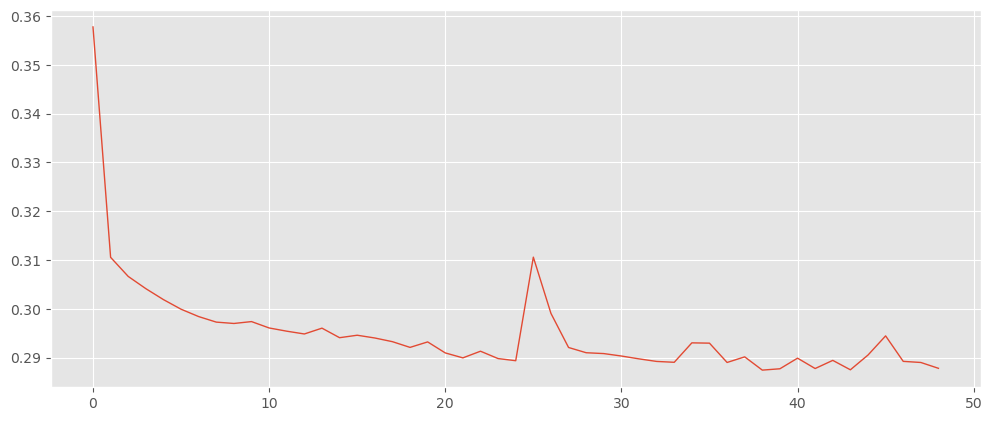

Test unnormalized error to compare to training loss:
0.28656393
38250
The following errors are calculated without the imputed observations!



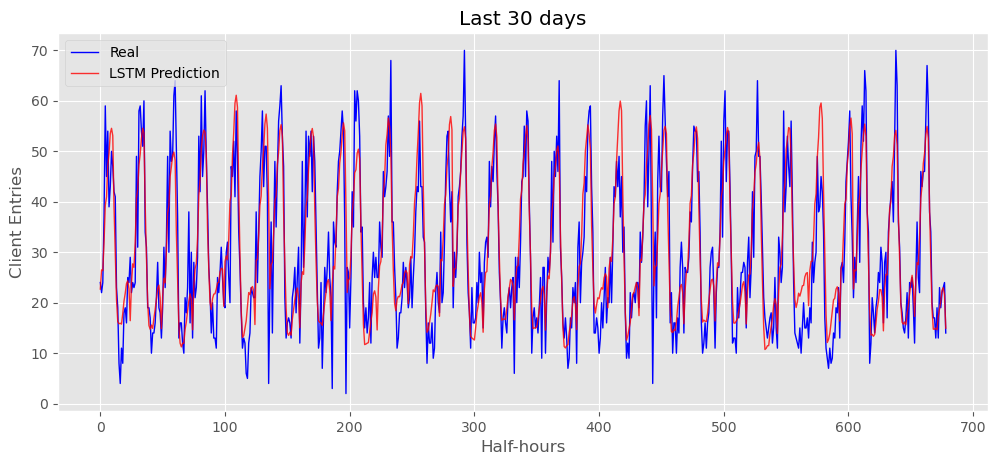

size of target and prediction:
679 679
Each n_output score, iteration 1 
RMSE 7.272907241848692
MAE 5.4758396
MAPE 29.041090607643127
MAAPE 21.33083939552307 

walkforward expanding: 2
total expansions: 3
(37426, 75, 1) (37426, 750)
Epoch 1/50
1170/1170 [==============================] - 7s 6ms/step - loss: 0.3570 - mae: 0.4411
Epoch 2/50
1170/1170 [==============================] - 7s 6ms/step - loss: 0.3119 - mae: 0.4069
Epoch 3/50
1170/1170 [==============================] - 7s 6ms/step - loss: 0.3080 - mae: 0.4036
Epoch 4/50
1170/1170 [==============================] - 6s 5ms/step - loss: 0.3053 - mae: 0.4011
Epoch 5/50
1170/1170 [==============================] - 7s 6ms/step - loss: 0.3033 - mae: 0.3991
Epoch 6/50
1170/1170 [==============================] - 7s 6ms/step - loss: 0.3014 - mae: 0.3972
Epoch 7/50
1170/1170 [==============================] - 7s 6ms/step - loss: 0.2997 - mae: 0.3954
Epoch 8/50
1170/1170 [==============================] - 6s 6ms/step - loss: 0.2988 - mae

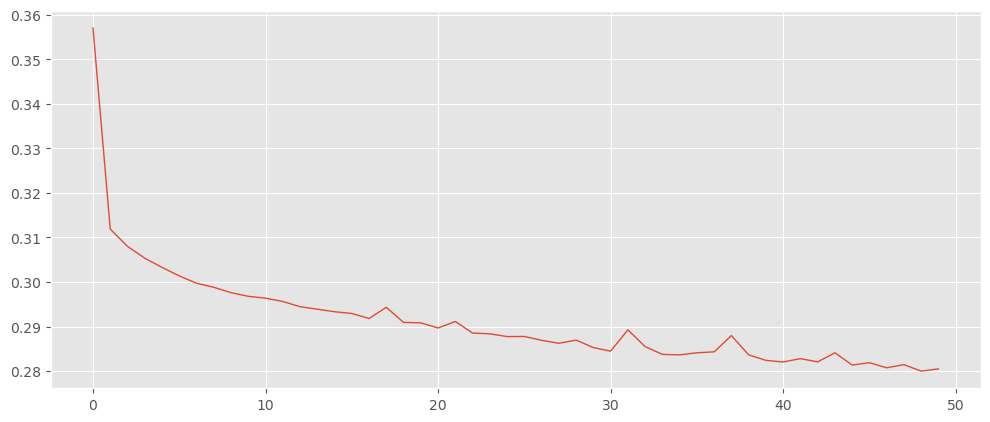

Test unnormalized error to compare to training loss:
0.24905062
39000
The following errors are calculated without the imputed observations!



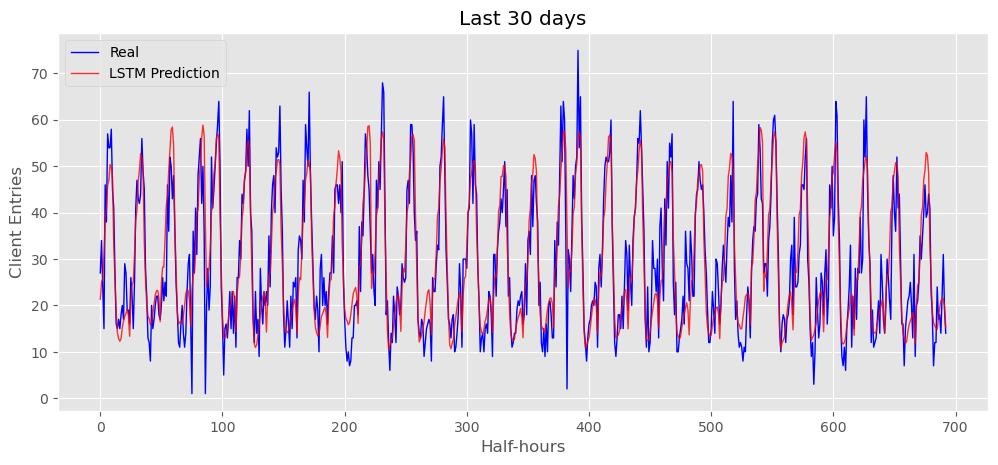

size of target and prediction:
693 693
Each n_output score, iteration 2 
RMSE 6.743016056146335
MAE 5.182894
MAPE 32.34369456768036
MAAPE 20.52614539861679 

walkforward expanding: 3
total expansions: 3
(38176, 75, 1) (38176, 750)
Epoch 1/50
1193/1193 [==============================] - 6s 5ms/step - loss: 0.3591 - mae: 0.4427
Epoch 2/50
1193/1193 [==============================] - 5s 5ms/step - loss: 0.3111 - mae: 0.4065
Epoch 3/50
1193/1193 [==============================] - 5s 5ms/step - loss: 0.3071 - mae: 0.4030
Epoch 4/50
1193/1193 [==============================] - 5s 5ms/step - loss: 0.3047 - mae: 0.4008
Epoch 5/50
1193/1193 [==============================] - 5s 5ms/step - loss: 0.3024 - mae: 0.3985
Epoch 6/50
1193/1193 [==============================] - 6s 5ms/step - loss: 0.2999 - mae: 0.3960
Epoch 7/50
1193/1193 [==============================] - 6s 5ms/step - loss: 0.2983 - mae: 0.3943
Epoch 8/50
1193/1193 [==============================] - 6s 5ms/step - loss: 0.2973 - mae: 

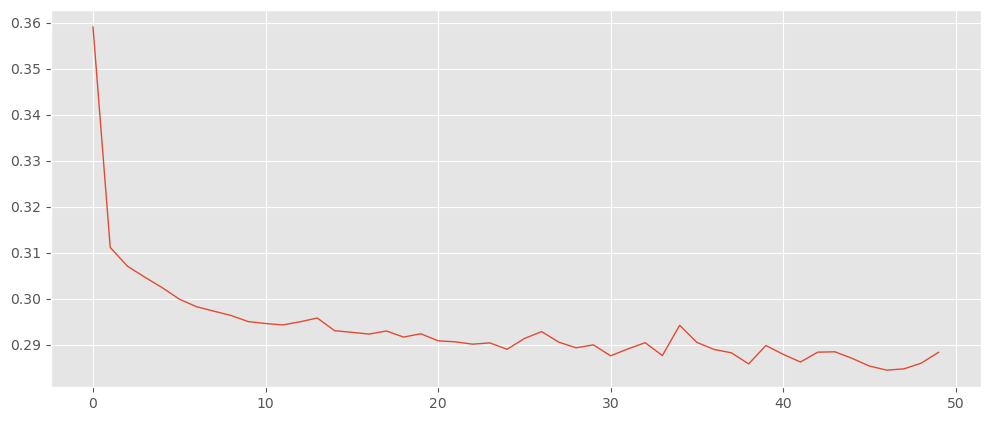

Test unnormalized error to compare to training loss:
0.27454868
39750
The following errors are calculated without the imputed observations!



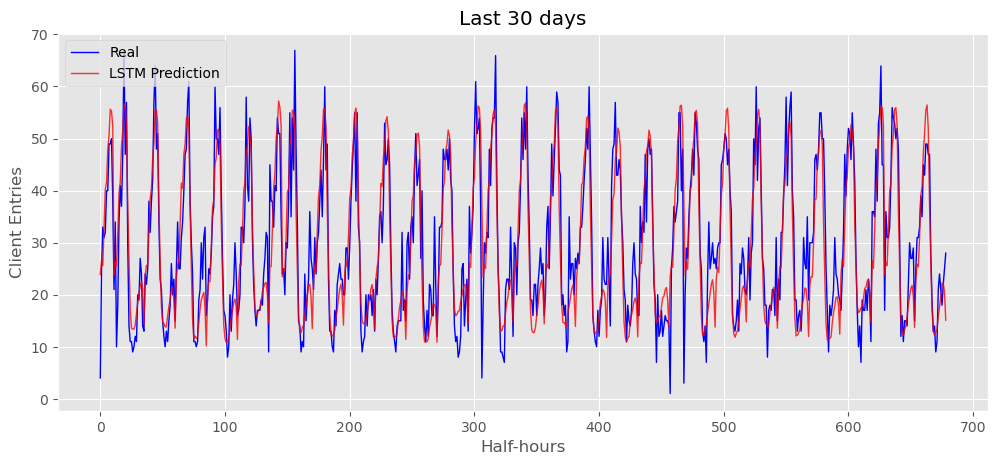

size of target and prediction:
679 679
Each n_output score, iteration 3 
RMSE 6.547962762967948
MAE 5.0347624
MAPE 25.594475865364075
MAAPE 18.858373165130615 

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
The lower visualizations are only useful if walkforward (and multiple predictions) is employed


In [16]:
#%matplotlib notebook
# history of windows, is updated for each prediction
history = [x for x in train]
# save predictions
predictions = list()
for i in range(len(test)):
    # grid_search hyperparameters?
    # HERE
    
    # Time Series CROSS-VALIDATION
    # we don't need to retrain all the time though!
    print("walkforward expanding: %s" % (i+1))
    print("total expansions: %s" % (len(test)))
    # the model is trained and retrained for every number of n_output to predict
    if walkforward or i == 0:
        model = build_model(array(history), n_input, n_output, stride)  
        train_size = len(history) # number of training windows
        len_train = train_size*n_output # actual training size/length
        if single_prediction:
            len_train = train_size
            

    # predict the next n_output steps
    yhat_sequence = forecast(model, history, n_input)
    
    print("Test unnormalized error to compare to training loss:") 
    print(mean_squared_error(array(test[i, :, 0]).flatten(), yhat_sequence))
    
    # invert the scaling on predictions
    yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    
    # invert scaling for real values
    test_y = invTransformTarget(scaler, array(test[i, :, 0]).flatten())
   
    # give the seasonal and trend components back
    if remove_components:
        # In development!!!
        predic1 = range(len_train, len_train+n_output)
        
        predic_halfday_cos = list(map(lambda x: cos(2*pi*x/(dataset_day/2.0)), predic1))
        predic_halfday_sin = list(map(lambda x: sin(2*pi*x/(dataset_day/2.0)), predic1))
        predic_day_cos = list(map(lambda x: cos(2*pi*x/dataset_day), predic1))
        predic_day_sin = list(map(lambda x: sin(2*pi*x/dataset_day), predic1))
        
        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_halfday = reg_model.coef_[0][3]*array(predic_halfday_cos) + reg_model.coef_[0][4]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_halfday
        
        sum_components = trend_seas
        yhat_sequence = [yhat_sequence[j]+sum_components[j] for j in range(n_output)]

        
    # store the predictions for later results
    predictions.append(yhat_sequence)
    
    if future_prediction and single_prediction:
        print(array(history).shape)
        next_test = test[i, :]
        next_test = next_test.reshape(next_test.shape[0], next_test.shape[1], n_features)
        for index, x in numpy.ndenumerate(next_test):
            history.append(x)
    else:
        history.append(test[i, :])
        
    
    #RENORMALIZE: after appending the real values back to the training data normalize again to not introduce bias
    if walkforward and not single_prediction:
        arr_history = array(history)
        n_windows = arr_history.shape[0]
        arr_history = invTransformTarget(scaler, arr_history.flatten())
        arr_history = arr_history.reshape(n_windows*n_output,n_features)
        arr_history = normalize_train(scaler, arr_history)
        history = list(arr_history.reshape(n_windows, n_output, n_features))
    
    
    #RENORMALIZE: after appending the real values back to the training data normalize again to not introduce bias
    if walkforward and future_prediction and single_prediction:
        print("Predicting the future...")
        arr_history = array(history)
        n_samples = arr_history.shape[0]
        arr_history = invTransformTarget(scaler, arr_history.flatten())
        arr_history = arr_history.reshape(n_samples,n_features)
        arr_history = normalize_train(scaler, arr_history)
        history = list(arr_history.reshape(n_samples, 1, n_features))
    
    
    if imputed:
        print(len_train)
        list_idx = []
        for idx in imputed_idx:
            if len_train-1<idx<len_train+n_output:
                list_idx.append(idx - len_train)
        if list_idx:
            yhat_sequence = numpy.delete(yhat_sequence,  list_idx)
            test_y = numpy.delete(test_y,  list_idx)  
            print("The following errors are calculated without the imputed observations!\n")
    
    if compare_imputed:
        list_idx = []
        for idx in remove_idx:
            if len_train-1<idx<len_train+n_output:
                list_idx.append(idx - len_train)
        if list_idx:
            yhat_sequence = numpy.delete(yhat_sequence,  list_idx)
            test_y = numpy.delete(test_y,  list_idx) 
            print("The following errors are calculated without observations that do not fit into the wanted schedule!\n")
            print(list_idx)
    #naive_yhat_sequence=dataset['clients_that_bought'].values[-1400-175+(175*i):-1400+(175*i)]
    # plot each iteration 
    pyplot.title('Last 30 days')
    pyplot.plot(test_y, color="blue", label="Real")
    pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="LSTM Prediction")
    #pyplot.plot(naive_yhat_sequence, alpha=0.8, color="green", label="Naive Predicted")
    #pyplot.xticks([0, 25, 50, 75, 100, 125, 150, 175], labels=['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08'])
    #pyplot.xticks([0, 172, 345, 519, 678], labels=['2019-06-23','2019-07-02','2019-07-09','2019-07-17','2019-07-23'])
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Half-hours")
    pyplot.ylabel("Client Entries")
    pyplot.show()
    
    print("size of target and prediction:")
    print(len(test_y), len(yhat_sequence))
    # Score only from the each modelled n_output
    rmse = sqrt(mean_squared_error(test_y, yhat_sequence))
    mae = mean(abs(test_y - yhat_sequence))
    mape = mean(abs(test_y - yhat_sequence) / test_y) * 100
    maape = mean_arctangent_absolute_percentage_error(test_y, yhat_sequence)
    print('Each n_output score, iteration %s \nRMSE %s' % (i+1, rmse))
    print('MAE %s' % (mae))
    print('MAPE %s' % (mape))
    print('MAAPE %s \n' % (maape))
    
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
#Image('model.png') 
# The question mark means that first dimension is not fixed in the graph and it can vary between run calls